In [1]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import funcoes as f
import warnings; 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
periodos = 12
oos = 1

stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date')
price_rets = f.returns(stock_prices).drop('BOVA11.SA', axis=1)

In [4]:
bova = f.returns(stock_prices['BOVA11.SA'])
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew)
rets_msr = f.pipeline(stock_prices, periodos, oos, algo=f.weight_gmv)
rets_erc = f.pipeline(stock_prices, periodos, oos, algo=f.weight_erc)

In [5]:
naive_portfolios_results = pd.DataFrame(
    {"BOVA11": bova[rets_ew.index.min():],
     "EW": rets_ew['rets'], 
     "MSR": rets_msr['rets'], 
     "ERC": rets_erc['rets']
    }
)

,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,0.04081,0.22358,0.04675,0.22616,-0.14158,-0.41984,-0.60601,6.07060,0.10696,0.13614
EW,0.12614,0.22290,0.41951,0.68410,-0.07668,-0.37872,-0.73768,7.14938,0.10081,0.12906
MSR,0.17647,0.22873,0.62298,0.84960,-0.05210,-0.41312,-0.69803,10.15817,0.09529,0.13181
ERC,0.20642,0.24632,0.69687,1.10084,-0.08610,-0.48141,-0.14703,7.36016,0.09496,0.12921


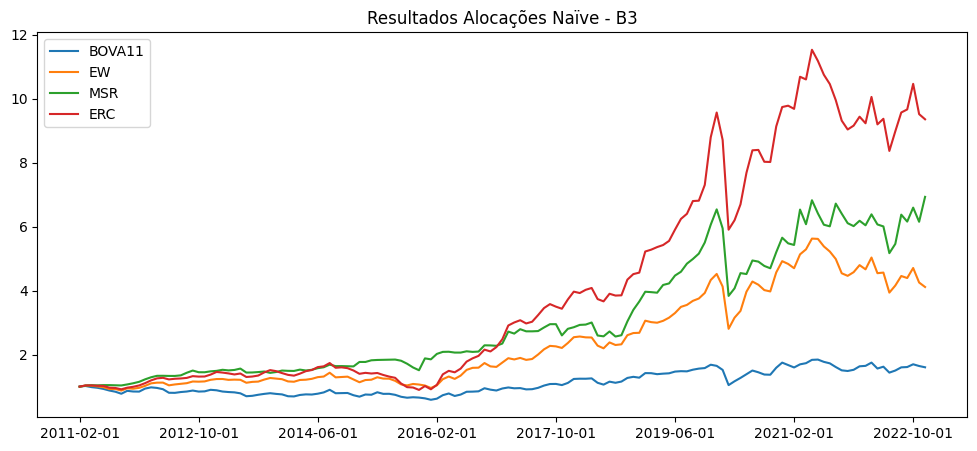

In [6]:
(1+naive_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naïve - B3");
f.summary_stats(naive_portfolios_results, .03)